<p style="font-size:30px; text-align:center; line-height:120%">
    <br> 
        <b>
        COMS 4761 Computational Genomics 
        <br></br>
            Protein Structure Prediction
        <br></br>
        </b> 
    <br> 
</p>
<p style="font-size:18px; text-align:left; line-height:120%">
    <br> 
        <b>
        Anushri Arora, Kirit Dhillon
        </b>
    <br> 
</p>

In [0]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from networkx.algorithms.components.connected import connected_components
import warnings
import networkx
import numpy as np
import json
import nltk
from nltk.corpus import stopwords
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install gensim

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
seqs = []
lines = []
with open('/content/drive/My Drive/correct_embeddings.txt', 'r') as f:
  lines = f.readlines()
  f.close()
lines = lines[1:]
for line in lines:
  seqs.append(line.split(' ')[0])

In [0]:
df = pd.DataFrame(seqs, columns=['seq'])
print(df.head())
print(df.shape)

                                       seq
0     MCMPCFTTDHQMARKCDDCCGGKGRGKCYGPQCLCR
1   DEAIRCTGTKDCYIPCRYITGCFNSRCINKSCKCYGCT
2  TIINVKCTSPKQCSKPCKELYGSSAGAKCMNGKCKCYNN
3      VVIGQRCYRSPDCYSACKKLVGKATGKCTNGRCDC
4   GVIINVKCKISRQCLEPCKKAGMRFGKCMNGKCHCTPK
(1343, 1)


In [0]:
wordmodelfile ='/content/drive/My Drive/correct_embeddings.txt'
wordmodel = KeyedVectors.load_word2vec_format(wordmodelfile, binary = False, limit=200000)

In [0]:
def seq_grams(s1):
    '''
    i/p:  protein sequence
    o/p:  list where each element has 3 chars 
    '''
    s1_words=[]
    for count in range(0,len(s1)-2):
        s1_words.append(s1[count:count+3])
        count+=3
    return s1_words

def similarityIndex(s1, s2, wordmodel):
    '''
    To compare two protein sequences and return their similarity score based on the gensim model
    '''
    if s1 == s2:
        return 1.0
    
    #s1words = seq_grams(s1)
    #s2words = seq_grams(s2)

    s1words = list(s1words)
    s2words = list(s2words)    

    s1set = set(s1words)
    s2set = set(s2words)

    vocab = wordmodel.vocab
    
    if len(s1set & s2set) == 0:
        return 0.0
    for word in s1set.copy():
        if (word not in vocab):
            s1words.remove(word)
    for word in s2set.copy():
        if (word not in vocab):
            s2words.remove(word)
    try:
        s = wordmodel.n_similarity(s1words, s2words)
    except:
        s = 0
    return s


In [0]:
s_1 = 'MCMPCFTTDHQMARKCDDCCGGKGRGKCYGPQCLCR'
s_2 = 'AGYDRHITIFSPEGRLYQVEYAFKATNQTNINSLAVRGKDCTVVISQKKVPDKLLDPTTVSYIFCISRTIGMVVNGPIPDARNAALRAKAEAAEFRYKYGYDMPCDVLAKRMANLSQIYTQRAYMRPLGVILTFVSVDEELGPSIYKTDPAGYYVGYKATATGPKQQEITTNLENHFKKSKIDHINEESWEKVVEFAITHMIDALGTEFSKNDLEVGVATKDKFFTLSAENIEERLVAIAEQD'
wordmodel.similarity(s_1, s_2)

0.92013067

In [0]:
n = df.shape[0]
similarity_matrix = [[-1 for c in range(n)] for r in range(n)]
row = 0
for seq_1 in df['seq']:
    print(row)
    column = 0
    for seq_2 in df['seq']:
        if seq_1 == seq_2:
            column += 1
            continue
        similarity_matrix[row][column] = wordmodel.similarity(seq_1, seq_2)
        column += 1
    row += 1

In [0]:
setlist = []
index = 0
for score_row, response in zip(similarity_matrix, df['seq']):
    max_sim_index = index
    if np.array(score_row).sum() > 0:
        max_sim_index = np.array(score_row).argmax()
    if set([response, df['seq'][max_sim_index]]) not in setlist:
        setlist.append([response, df['seq'][max_sim_index]])
    index += 1

In [0]:
def toGraph(l):
    '''
    It takes in a list of lists and returns a graph object, 
    assigning nodes and edges from each sub-list object
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(toEdges(part))
    return G

def toEdges(l):
    '''
    It treats args(1) 'l' as a graph and returns (implicitly) it's edges 
    '''
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current 

In [0]:
G = toGraph(setlist)
setlist = list(connected_components(G))

In [0]:
novel_sub_categories = {}
index = 0
for category in setlist:
    novel_sub_categories[index] = list(category)
    index += 1

result = novel_sub_categories
pprint.pprint(result)

In [0]:
with open('unirep_clusters.json', 'w') as temp:
    json.dump(result, temp)

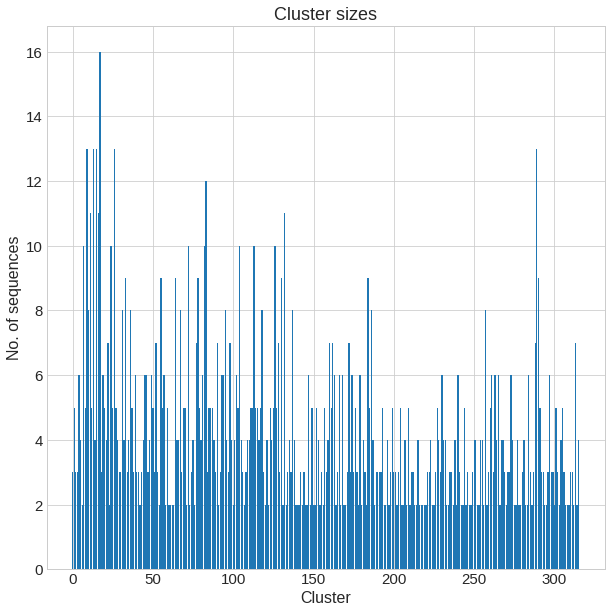

In [0]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10))
x = result.keys()
y = [len(value) for value in result.values()]
plt.bar(x, y)
plt.title("Cluster sizes", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("No. of sequences", size = 16)
plt.tick_params(labelsize=15);

In [0]:
# Get clusters with more than one sequence
def get_multiple_seq_clusters(result):
    clusters = {}
    count = 0
    for k, v in result.items():
        if len(v) > 2:
            clusters[count] = v
            count+=1
    return clusters

In [0]:
clusters = get_multiple_seq_clusters(result)
#pprint.pprint(clusters)

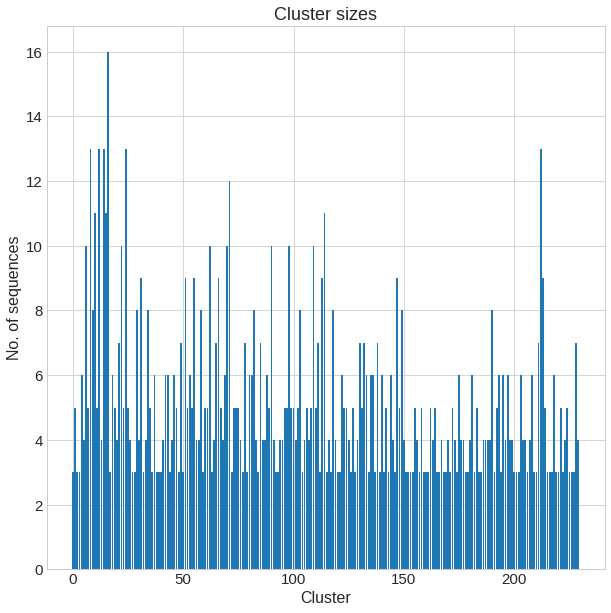

In [0]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10))
x = clusters.keys()
y = [len(value) for value in clusters.values()]
plt.bar(x, y)
plt.title("Cluster sizes", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("No. of sequences", size = 16)
plt.tick_params(labelsize=15);

In [0]:
pprint.pprint(len(wordmodel.vocab))

1343


In [0]:
vocab = wordmodel.vocab
vector_reps = []
word_vector={}
for s in vocab:
  word_vector[s]=wordmodel.wv[s]
  vector_reps.append(wordmodel.wv[s])

In [0]:
len(word_vector)
pprint.pprint(word_vector)


### **Agglomerative Clustering**

In [0]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 149).fit(vector_reps)

In [0]:
def index_of_item(all_vectors,value):
 i=0
 for val in all_vectors:
   if  np.array_equal(val,value):
     return i
   else:
     i+=1 

In [60]:
print(index_of_item(all_vectors,vector_rep))


0


In [0]:
len(vector_reps)
len(clustering.labels_)
word_vector
vector_to_cluster={} 
all_vectors = list(word_vector.values())
all_words = list(word_vector.keys())

i=0
for cluster_id in clustering.labels_:
  if cluster_id not in vector_to_cluster.keys():
    vector_to_cluster[cluster_id]=[]
  vector_rep = vector_reps[i]
  all_vectors = list(word_vector.values())
  all_words = list(word_vector.keys())
  list_index = index_of_item(all_vectors,vector_rep)
  vector_to_cluster[cluster_id].append(all_words[list_index])
  i+=1
print(len(vector_to_cluster))
pprint.pprint(vector_to_cluster)

In [0]:
temp = list(clustering.labels_)
clustering_labels=[]
for i in range(0,150):
  clustering_labels.append(temp.count(i)) 

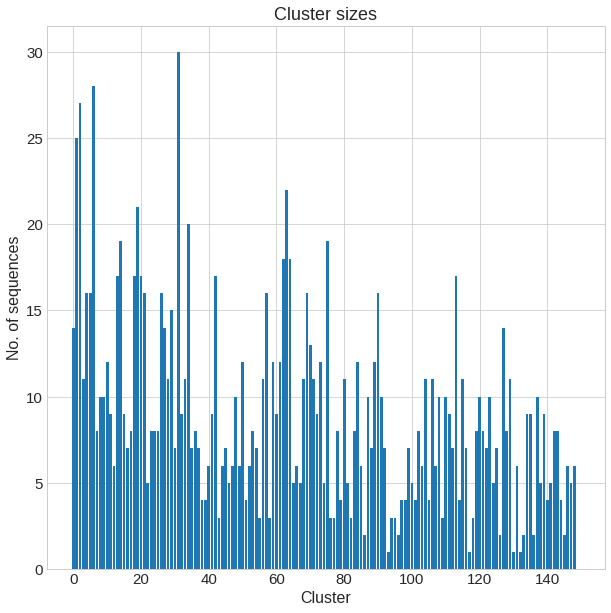

In [0]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10))
x = [i for i in range(0,150)]
y = clustering_labels
plt.bar(x, y)
plt.title("Cluster sizes", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("No. of sequences", size = 16)
plt.tick_params(labelsize=15);

In [0]:
### Visualize Correctness of Clustering

In [0]:
import json
f = open('/content/drive/My Drive/seq_to_family.json')
seq_to_family = json.load(f)

In [0]:
f2 = open('/content/drive/My Drive/unirep_clusters.json')
unirep_clusters = json.load(f2)

In [0]:
pprint.pprint(unirep_clusters)

In [0]:
ratios_2 = []
for cluster_id, seqs in unirep_clusters.items():
  num_correct = 0
  total = len(seqs)
  families = []
  for seq in seqs:
    if seq_to_family[seq] not in families:
      families.append(seq_to_family[seq])
  num_correct = len(families)
  ratios_2.append(num_correct/total)

In [0]:
pprint.pprint(len(ratios))

316


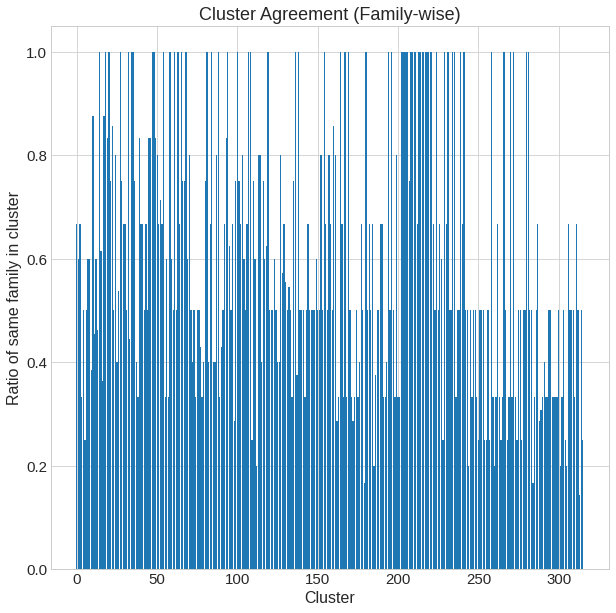

In [0]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10))
x = [i for i in range(0,316)]
y = ratios_1
plt.bar(x, y)
plt.title("Cluster Agreement (Family-wise)", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("Ratio of same family in cluster", size = 16)
plt.tick_params(labelsize=15);

In [0]:
def assign_color_to_ratio(ratios):
    colors = []
    for ratio in ratios:
        if ratio < 0.25:
            colors.append('red')
        elif ratio < 0.5:
            colors.append('orange')
        else:
            colors.append('green')
    return colors

Text(0, 0.5, 'Similarity Ratio')

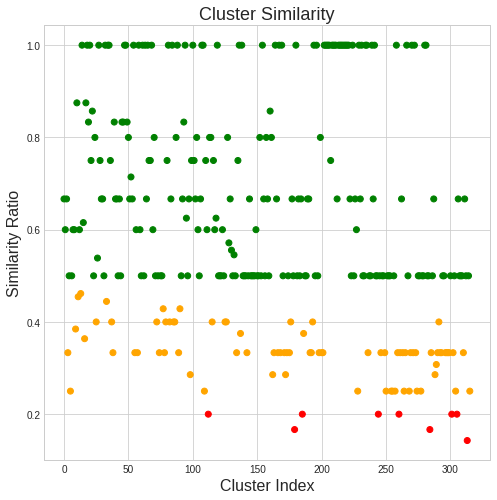

In [0]:
fig = plt.figure(figsize=(8,8))
x = [i for i in range(0,316)]
y = ratios_2
color_vals = assign_color_to_ratio(y)
plt.scatter(x, y, c=color_vals)
plt.title("Cluster Similarity", size=18)
plt.xlabel("Cluster Index", size=16)
plt.ylabel("Similarity Ratio", size=16)

**Aglommerative Clustering Results**

In [0]:
ratios_1 = []
for cluster_id, seqs in vector_to_cluster.items():
  num_correct = 0
  total = len(seqs)
  families = []
  for seq in seqs:
    if seq_to_family[seq] not in families:
      families.append(seq_to_family[seq])
  num_correct = len(families)
  ratios_1.append(num_correct/total)


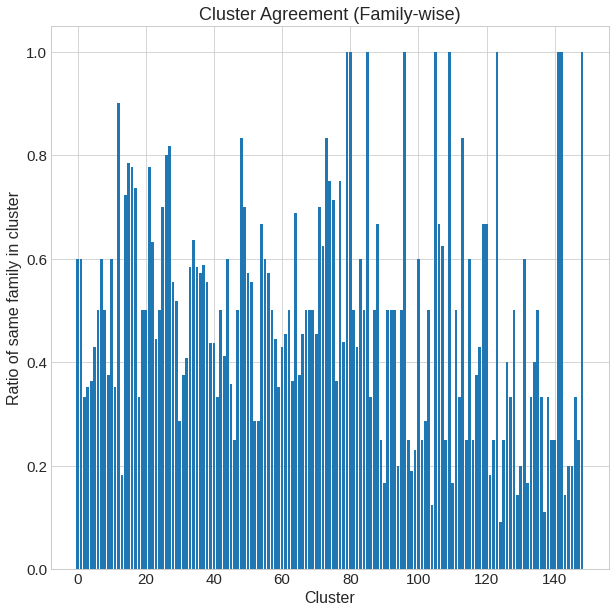

In [73]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10))
x = [i for i in range(0,149)]
y = ratios_2
plt.bar(x, y)
plt.title("Cluster Agreement (Family-wise)", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("Ratio of same family in cluster", size = 16)
plt.tick_params(labelsize=15);

Text(0, 0.5, 'Similarity Ratio')

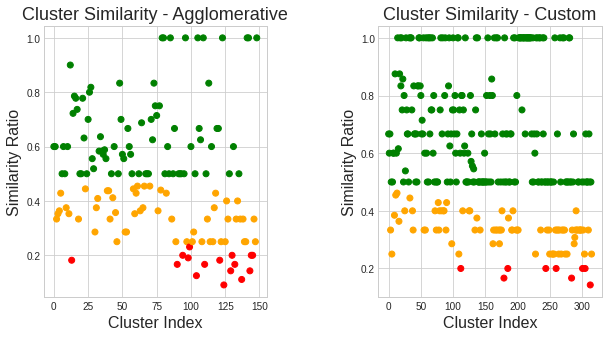

In [124]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=1, wspace=0.5)
plt.subplot(1, 2, 1)
x = [i for i in range(0,149)]
y = ratios_1
color_vals = assign_color_to_ratio(y)
plt.scatter(x, y, c=color_vals)
plt.title("Cluster Similarity - Agglomerative", size=18)
plt.xlabel("Cluster Index", size=16)
plt.ylabel("Similarity Ratio", size=16)

plt.subplot(1, 2, 2)
x = [i for i in range(0,316)]
y = ratios_2

color_vals = assign_color_to_ratio(y)
plt.scatter(x, y, c=color_vals)
plt.title("Cluster Similarity - Custom", size=18)
plt.xlabel("Cluster Index", size=16)
plt.ylabel("Similarity Ratio", size=16)

In [0]:
def efficiency_of_ratios(ratios):
  red=0.0
  orange=0.0
  green=0.0
  for ratio in ratios:
    if ratio < 0.25:
      red+=1
    elif ratio < 0.5:
      orange+=1
    else:
      green+=1
  return red/len(ratios), orange/len(ratios), green/len(ratios)

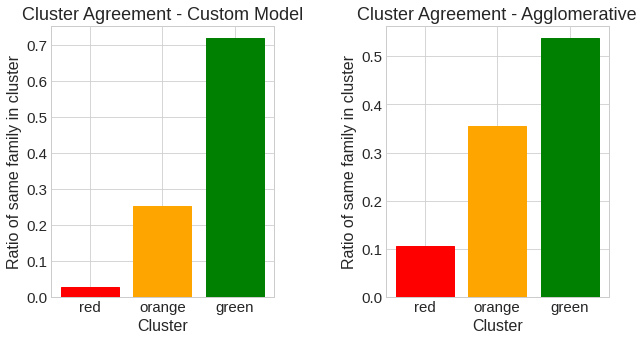

In [123]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=1, wspace=0.5)

plt.subplot(1, 2, 1)
plt.style.use('seaborn-whitegrid')
# fig = plt.figure(figsize=(8, 8))
x = ['red', 'orange', 'green']
y = efficiency_of_ratios(ratios_2)
barlist = plt.bar(x, y)
barlist[0].set_color('r')
barlist[1].set_color('#FFA500')
barlist[2].set_color('g')
plt.title("Cluster Agreement - Custom Model", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("Ratio of same family in cluster", size = 16)
plt.tick_params(labelsize=15);

plt.subplot(1, 2, 2)
plt.style.use('seaborn-whitegrid')
# fig = plt.figure(figsize=(8, 8))
x = ['red', 'orange', 'green']
y = efficiency_of_ratios(ratios_1)
barlist = plt.bar(x, y)
barlist[0].set_color('r')
barlist[1].set_color('#FFA500')
barlist[2].set_color('g')
plt.title("Cluster Agreement - Agglomerative", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("Ratio of same family in cluster", size = 16)
plt.tick_params(labelsize=15);